### Grammy Awards EDA

In [1]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
#Edit the .env file 
dotenv_path = os.path.join('..', 'config', 'postgres_sqlalchemy.env')
load_dotenv(dotenv_path=dotenv_path)

# Enviroment variables with os.getenv
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')

print(DB_NAME, DB_USER)

postgres airflow


In [3]:
def read_csv(path):
    return pd.read_csv(path)

def make_db_engine():
    return create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

def load_data(df, table_name):
    engine = make_db_engine()
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)

def loading_data(path, table_name):
    df = read_csv(path)
    load_data(df, table_name)

# Make query and see it df
def query_data(sql_query):
    engine = make_db_engine()
    with engine.connect() as connection:
        return pd.read_sql(sql_query, connection)
    

## Data Understanding


Loading the data in the new table grammyAwards

In [4]:
loading_data('../csvs/the_grammy_awards.csv', 'grammyAwards')

Note: I use no limit here to take all the data, 4810 rows x 10 columns to the df

In [5]:
# Consulta
sql_query = 'SELECT * FROM "grammyAwards"'
df = query_data(sql_query)
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [6]:
df.describe()

,year
count,4810.000000
mean,1995.566944
std,17.149720
min,1958.000000
25%,1983.000000
50%,1998.000000
75%,2010.000000
max,2019.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


C:\Users\davel\AppData\Local\Temp\ipykernel_17676\669679768.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")


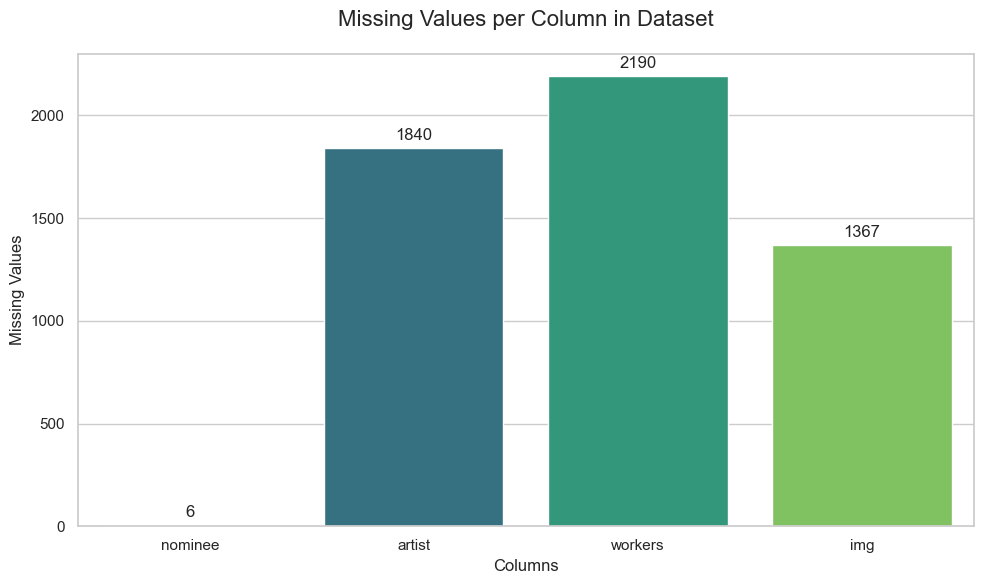

In [10]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")

plt.xlabel('Columns', fontsize=12)
plt.ylabel('Missing Values', fontsize=12)
plt.title('Missing Values per Column in Dataset', fontsize=16, pad=20)

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()


**Important observation!**
- Taking a look at the missing values ​​we can realize that it is an error when registering because there are nominations directly to artists and the 'artist' field is not filled in, the names of the artists are also seen in 'workers' '. Which makes me think to complement it with the other set of data.

In [11]:
n = 25
print(f"{'Nominee':<30} | {'Artist':<30} | {'Workers':<30}") 
print("-" * 95)  

for i in range(n):
    nominee = df.loc[i, 'nominee'] if not pd.isnull(df.loc[i, 'nominee']) else 'N/A'
    artist = df.loc[i, 'artist'] if not pd.isnull(df.loc[i, 'artist']) else 'N/A'
    workers = df.loc[i, 'workers'] if not pd.isnull(df.loc[i, 'workers']) else 'N/A'
    
    print(f"{nominee:<30} | {artist:<30} | {workers:<30}")


Nominee                        | Artist                         | Workers                       
-----------------------------------------------------------------------------------------------
Bad Guy                        | Billie Eilish                  | Finneas O'Connell, producer; Rob Kinelski & Finneas O'Connell, engineers/mixers; John Greenham, mastering engineer
Hey, Ma                        | Bon Iver                       | BJ Burton, Brad Cook, Chris Messina & Justin Vernon, producers; BJ Burton, Zach Hanson & Chris Messina, engineers/mixers; Greg Calbi, mastering engineer
7 rings                        | Ariana Grande                  | Charles Anderson, Tommy Brown, Michael Foster & Victoria Monet, producers; Serban Ghenea, John Hanes, Billy Hickey & Brendan Morawski, engineers/mixers; Randy Merrill, mastering engineer
Hard Place                     | H.E.R.                         | Rodney “Darkchild” Jerkins, producer; Joseph Hurtado, Jaycen Joshua, Derek Keota & Miki 

"Bad Guy| N/A | Billie Eilish O'Connell & Finneas O'Connell, songwriters (Billie Eilish)" It is an example of fingering when registering the workers, the artist is mentioned in that column.

In [12]:
best_new_artist_df = df[df['category'] == 'Best New Artist']

print(f"{'Nominee':<30} | {'Artist':<30} | {'Workers':<30}")
print("-" * 90)

for _, row in best_new_artist_df.iterrows():
    nominee = row['nominee'] if not pd.isnull(row['nominee']) else 'N/A'
    artist = row['artist'] if not pd.isnull(row['artist']) else 'N/A'
    workers = row['workers'] if not pd.isnull(row['workers']) else 'N/A'
    print(f"{nominee:<30} | {artist:<30} | {workers:<30}")


Nominee                        | Artist                         | Workers                       
------------------------------------------------------------------------------------------
Billie Eilish                  | N/A                            | N/A                           
Black Pumas                    | N/A                            | N/A                           
Lil Nas X                      | N/A                            | N/A                           
Lizzo                          | N/A                            | N/A                           
Maggie Rogers                  | N/A                            | N/A                           
ROSALÍA                        | N/A                            | N/A                           
Tank And The Bangas            | N/A                            | N/A                           
Yola                           | N/A                            | N/A                           
Dua Lipa                       | N/A

Here we can realize that the names of the artists or workers are not added due to the 'category' of the nomination.

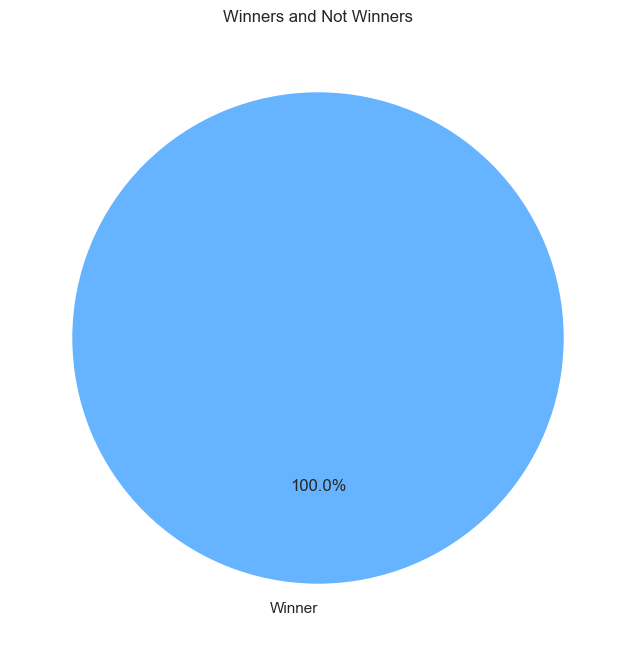

In [25]:
winner_counts = df['winner'].value_counts()

labels = ['Winner' if index else 'Not Winner' for index in winner_counts.index]

plt.figure(figsize=(8, 8))  
plt.pie(winner_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Winners and Not Winners')
plt.show()


It seems strange to me that all the data are winners, apparently all the data is just nominees.

In [26]:
for column in df.select_dtypes(include=['object', 'bool']).columns:
    print(f"\nDistribución de {column}:")
    print(df[column].value_counts())



Distribución de title:
title
62nd Annual GRAMMY Awards  (2019)    433
51st Annual GRAMMY Awards  (2008)    111
50th Annual GRAMMY Awards  (2007)    111
49th Annual GRAMMY Awards  (2006)    110
52nd Annual GRAMMY Awards  (2009)    109
                                    ... 
11th Annual GRAMMY Awards  (1968)     40
3rd Annual GRAMMY Awards  (1960)      39
5th Annual GRAMMY Awards  (1962)      39
2nd Annual GRAMMY Awards  (1959)      35
1st Annual GRAMMY Awards  (1958)      28
Name: count, Length: 62, dtype: int64

Distribución de published_at:
published_at
2017-11-28 00:03:45-08:00    4205
2020-05-19 05:10:28-07:00     433
2018-12-06 23:48:49-08:00      86
2018-05-22 03:08:24-07:00      86
Name: count, dtype: int64

Distribución de updated_at:
updated_at
2019-09-10 01:08:19-07:00    778
2019-09-10 01:06:11-07:00    754
2019-09-10 01:07:37-07:00    713
2019-09-10 01:06:59-07:00    681
2019-09-10 01:11:09-07:00    658
2019-09-10 01:09:02-07:00    554
2020-05-19 05:10:28-07:00    433
2017

In [46]:
category_counts = df['category'].value_counts()

print(category_counts)


category
Song Of The Year                                                   70
Record Of The Year                                                 69
Album Of The Year                                                  66
Best Opera Recording                                               64
Best Album Notes                                                   63
                                                                   ..
Best Contemporary Vocal Performance By A Duo, Group Or Chorus       1
Best R&B Performance By A Duo Or Group, Vocal Or Instrumental       1
Best Sacred Performance (Musical)                                   1
Best Jazz Performance - Small Group Or Soloist With Small Group     1
Best Classical Performance - Operatic Or Choral                     1
Name: count, Length: 638, dtype: int64


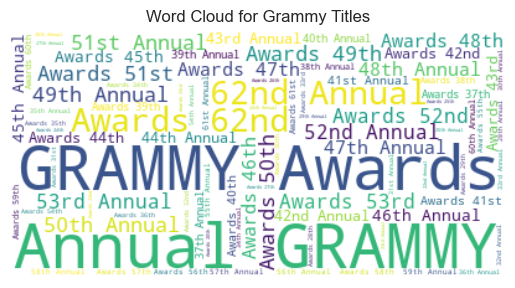

In [28]:
from wordcloud import WordCloud

text = ' '.join(df['title'].dropna().tolist())
wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Grammy Titles')
plt.show()


## Data transformation

Looking to transform any error and order the data. 

In [ ]:
df['published_at'] = pd.to_datetime(df['published_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df.head()


In [45]:
same_timestamp = (df['published_at'] == df['updated_at'])
print(f"Records with the same publication and update date: {same_timestamp.sum()} de {len(df)}")


Records with the same publication and update date: 541 de 4810


It has information about the update of the information but we can see that it does not contribute much to our purpose to know when it was updated, so it does not contribute to the objective of our Dashboard, in addition the img column only contains links that are not updated, it does not work either. 

In [47]:
df = df.drop(columns=['updated_at', 'img'])

## Visuals


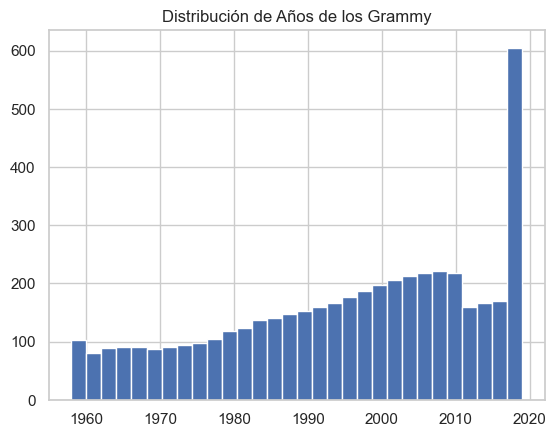

In [27]:
df['year'].hist(bins=30)
plt.title('Distribución de Años de los Grammy')
plt.show()


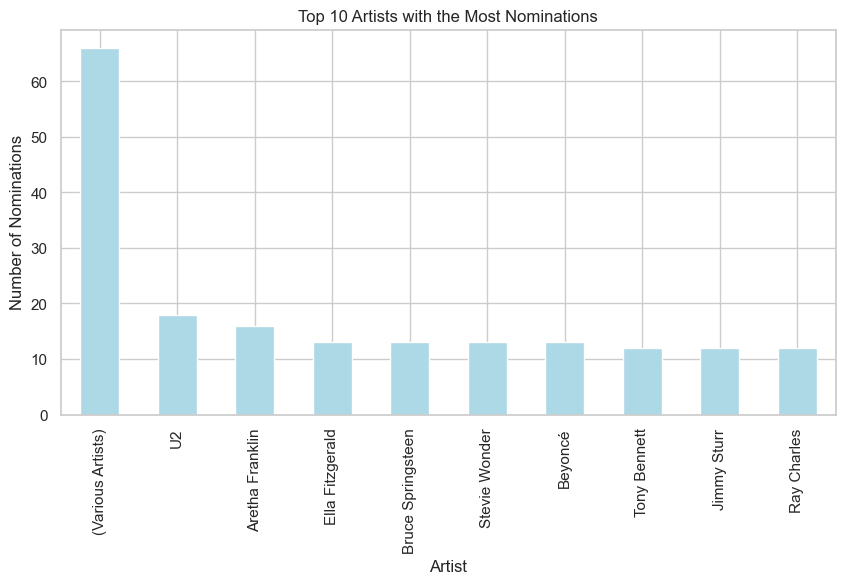

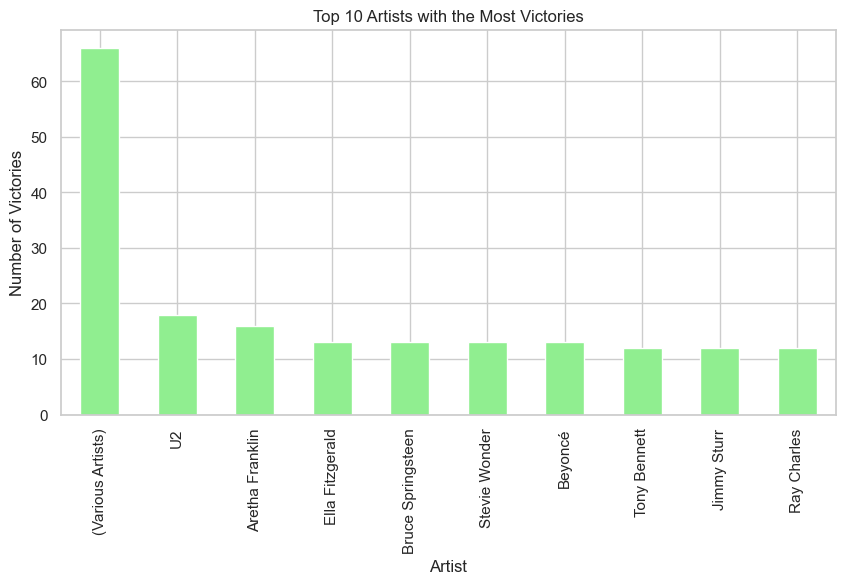

In [32]:
artist_nominations = df['artist'].value_counts()
artist_wins = df[df['winner'] == True]['artist'].value_counts()

plt.figure(figsize=(10, 5))
artist_nominations.head(10).plot(kind='bar', color='lightblue')
plt.title('Top 10 Artists with the Most Nominations')
plt.xlabel('Artist')
plt.ylabel('Number of Nominations')
plt.show()

plt.figure(figsize=(10, 5))
artist_wins.head(10).plot(kind='bar', color='lightgreen')
plt.title('Top 10 Artists with the Most Victories')
plt.xlabel('Artist')
plt.ylabel('Number of Victories')
plt.show()

Curiously, the data is the same, there are no non-winners, only nominees.

C:\Users\davel\AppData\Local\Temp\ipykernel_17676\3658472917.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


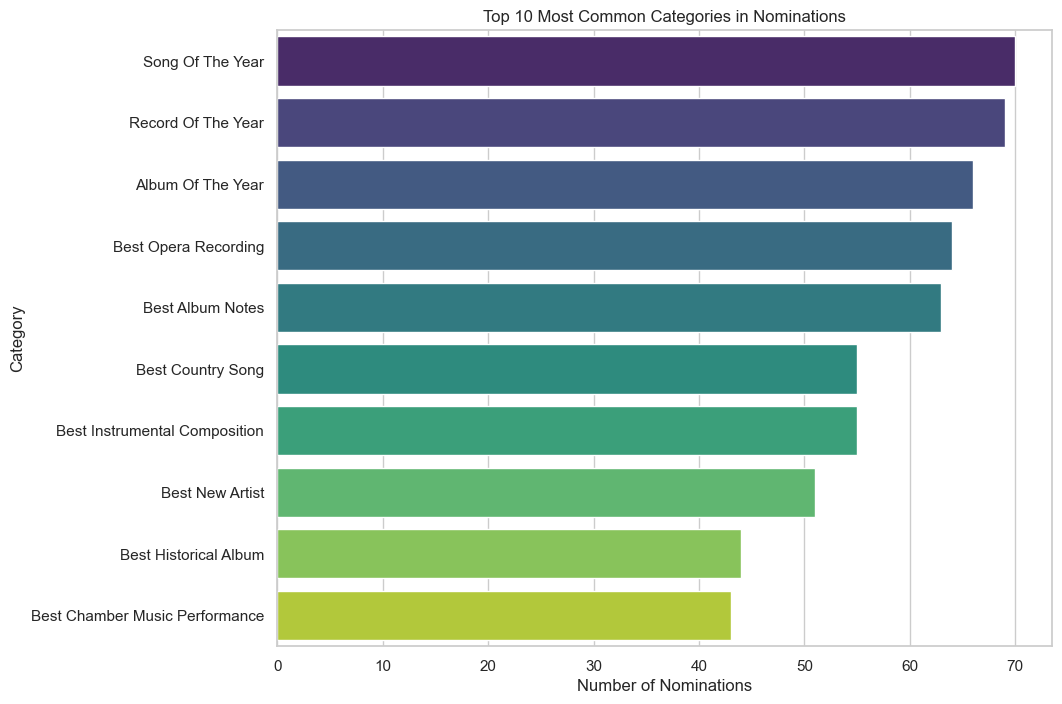

In [38]:
top_categories = category_counts.head(10)  

plt.figure(figsize=(10, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis') 
plt.title('Top 10 Most Common Categories in Nominations')
plt.xlabel('Number of Nominations')
plt.ylabel('Category')
plt.show()

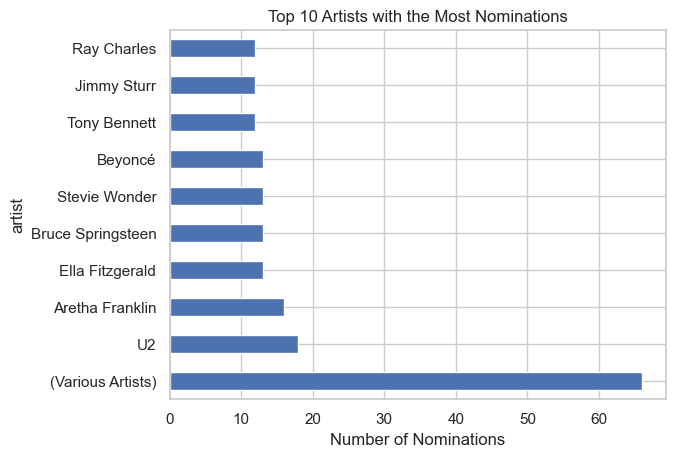

In [ ]:
df['artist'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Artists with the Most Nominations')
plt.xlabel('Number of Nominations')
plt.show()


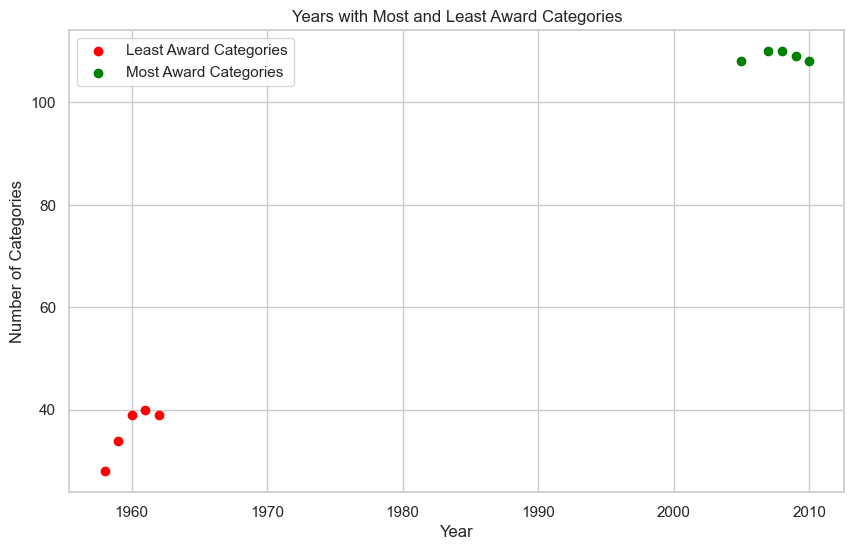

In [ ]:
category_counts_by_year = df.groupby('year')['category'].nunique()

sorted_counts = category_counts_by_year.sort_values()

least_award_categories = sorted_counts.head()
most_award_categories = sorted_counts.tail()

plt.figure(figsize=(10, 6))

plt.scatter(least_award_categories.index, least_award_categories, color='red', label='Least Award Categories')

plt.scatter(most_award_categories.index, most_award_categories, color='green', label='Most Award Categories')

plt.title('Years with Most and Least Award Categories')
plt.xlabel('Year')
plt.ylabel('Number of Categories')
plt.legend()  
plt.grid(True)  
plt.show()
